In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings ("ignore")

# Load Modules

In [2]:
import tensorflow as tf
print ("GPU is", "available" if tf.config.list_physical_devices ('GPU') else "not available")

GPU is available


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sklearn for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow sequential model
from tensorflow import keras
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Download the data

In [12]:
download_required = True

if download_required:
    # Download preprocessed data
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/'+ \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    data = pd.read_csv (address)
    
    # Create a data subfolder if one does not already exists
    import os
    data_directory = './Data/'
    if not os.path.exists (data_directory):
        os.makedirs (data_directory)
        
    # Save the data
    data.to_csv (data_directory + 'processed_data.csv', index = False)

# Define function to scale data

In [18]:
def scale_data (X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialize a new scaling object for normalizing input data
    sc = MinMaxScaler()
    
    # Set up the scalar just on the training data
    sc.fit (X_train)
    
    # Apply the scalar to the training and test sets
    train_sc = sc.transform (X_train)
    test_sc = sc.transform (X_test)
    
    return train_sc, test_sc

# Load the data

In [14]:
data = pd.read_csv ('./Data/processed_data.csv')

# make all data float type
data = data.astype ('float32')
data.drop ('PassengerId', axis = 1)
X = data.drop ('Survived', axis = 1)
y = data['Survived']

# Convert to numpy arrays as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up Neural Net

In [15]:
def make_net (number_features,
              hidden_layers = 3,
              hidden_layer_neurons = 128,
              dropout = 0.0,
              learning_rate = 0.003):
    
    """Make Tensorflow Neural Network"""
    
    # Clear Tensorflow
    k.clear_session()
    
    # Set up neural net
    net = Sequential ()
    
    # Add hidden layers using a loop
    for i in range (hidden_layers):
        # Add a fully connected layer with Relu activation
        net.add (Dense (
            hidden_layer_neurons,
            input_dim = number_features,         # num of input to the first layer ONLY
            activation = 'relu'))
        
        # Add a dropout layer
        net.add (Dropout (dropout))
    
    # Add a final sigmoid activation output
    net.add (Dense (1, activation = 'sigmoid'))
    
    # Compile the network
    opt = Adam (lr = learning_rate)
    
    net.compile (loss = 'binary_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])
    
    return net

# Show summary of the model structure

In [16]:
# This is an ARBITRARY model (NOT representative of the final model)
model = make_net (10)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

# Split and Scale the data

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split (X_np, y_np, test_size = 0.25, random_state = 42)

# Scale the data
X_train_sc, X_test_sc = scale_data (X_train, X_test)

In [22]:
X_train[:1]

array([[299. ,   1. ,  28. ,   0. ,   0. ,  30.5,   1. ,   0. ,   0. ,
        106. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,
          1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]], dtype=float32)

In [23]:
X_train_sc[:1]

array([[0.33483145, 0.        , 0.3465695 , 0.        , 0.        ,
        0.05953203, 1.        , 0.        , 0.        , 0.828125  ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

# Function to calculate accuracy

In [26]:
def calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test):
    """Calculate and print accuracy of training and testing set"""
    
    # Get accuracy of fit to training data
    probability = model.predict (X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten ()
    accuracy_train = np.mean (y_pred_train == y_train)
    
    # Get accuracy of fit to test data
    probability = model.predict (X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten ()
    accuracy_test = np.mean (y_pred_test == y_test)
    
    print (f"Training accuracy: {accuracy_train: 0.3f}")
    print (f"Test accuracy:  {accuracy_test: 0.3f}")

In [27]:
def plot_training (history_dict):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range (1, len (acc_values) + 1)
    
    plt.plot (epochs, acc_values, 'bo', label = 'Training acc')
    plt.plot (epochs, val_acc_values, 'b', label = 'Test acc')
    plt.title ('Training and Testing accuracy')
    plt.xlabel ('Epochs')
    plt.ylabel ('Accuracy')
    plt.legend ()
    
    plt.show ()

# Run the model

In [30]:
number_features = X_train_sc.shape [1]
model = make_net (number_features)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3328      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [31]:
history = model.fit (X_train_sc,
                     y_train,
                     epochs = 250,
                     batch_size = 64,
                     validation_data = (X_test_sc, y_test),
                     verbose = 1)

Train on 668 samples, validate on 223 samples
Epoch 1/250
668/668 [==============================] - 1s 999us/sample - loss: 0.5836 - accuracy: 0.6572 - val_loss: 0.5384 - val_accuracy: 0.7623
Epoch 2/250
668/668 [==============================] - 0s 61us/sample - loss: 0.4946 - accuracy: 0.7919 - val_loss: 0.4769 - val_accuracy: 0.7803
Epoch 3/250
668/668 [==============================] - 0s 58us/sample - loss: 0.4469 - accuracy: 0.7994 - val_loss: 0.4463 - val_accuracy: 0.7982
Epoch 4/250
668/668 [==============================] - 0s 62us/sample - loss: 0.4252 - accuracy: 0.8263 - val_loss: 0.4448 - val_accuracy: 0.8027
Epoch 5/250
668/668 [==============================] - 0s 60us/sample - loss: 0.4107 - accuracy: 0.8338 - val_loss: 0.4462 - val_accuracy: 0.8072
Epoch 6/250
668/668 [==============================] - 0s 58us/sample - loss: 0.4053 - accuracy: 0.8293 - val_loss: 0.4350 - val_accuracy: 0.8206
Epoch 7/250
668/668 [==============================] - 0s 58us/sample - loss:

668/668 [==============================] - 0s 61us/sample - loss: 0.2386 - accuracy: 0.9012 - val_loss: 0.8283 - val_accuracy: 0.8161
Epoch 57/250
668/668 [==============================] - 0s 65us/sample - loss: 0.2513 - accuracy: 0.8832 - val_loss: 0.8038 - val_accuracy: 0.8161
Epoch 58/250
668/668 [==============================] - 0s 61us/sample - loss: 0.2377 - accuracy: 0.9057 - val_loss: 0.8537 - val_accuracy: 0.8072
Epoch 59/250
668/668 [==============================] - 0s 54us/sample - loss: 0.2448 - accuracy: 0.8982 - val_loss: 0.7139 - val_accuracy: 0.8341
Epoch 60/250
668/668 [==============================] - 0s 57us/sample - loss: 0.2489 - accuracy: 0.8937 - val_loss: 0.7299 - val_accuracy: 0.8296
Epoch 61/250
668/668 [==============================] - 0s 58us/sample - loss: 0.2450 - accuracy: 0.8922 - val_loss: 0.8091 - val_accuracy: 0.8206
Epoch 62/250
668/668 [==============================] - 0s 58us/sample - loss: 0.2492 - accuracy: 0.8892 - val_loss: 0.8065 - val_a

Epoch 112/250
668/668 [==============================] - 0s 55us/sample - loss: 0.1713 - accuracy: 0.9296 - val_loss: 1.2831 - val_accuracy: 0.8161
Epoch 113/250
668/668 [==============================] - 0s 57us/sample - loss: 0.1698 - accuracy: 0.9311 - val_loss: 1.3114 - val_accuracy: 0.8117
Epoch 114/250
668/668 [==============================] - 0s 55us/sample - loss: 0.1655 - accuracy: 0.9341 - val_loss: 1.3479 - val_accuracy: 0.8072
Epoch 115/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1664 - accuracy: 0.9341 - val_loss: 1.4018 - val_accuracy: 0.8161
Epoch 116/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1709 - accuracy: 0.9341 - val_loss: 1.2929 - val_accuracy: 0.8341
Epoch 117/250
668/668 [==============================] - 0s 54us/sample - loss: 0.1787 - accuracy: 0.9296 - val_loss: 1.5512 - val_accuracy: 0.7982
Epoch 118/250
668/668 [==============================] - 0s 55us/sample - loss: 0.2045 - accuracy: 0.9237 - val_

668/668 [==============================] - 0s 61us/sample - loss: 0.1449 - accuracy: 0.9446 - val_loss: 1.8280 - val_accuracy: 0.8027
Epoch 168/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1550 - accuracy: 0.9341 - val_loss: 1.8779 - val_accuracy: 0.8206
Epoch 169/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1483 - accuracy: 0.9356 - val_loss: 1.7069 - val_accuracy: 0.8206
Epoch 170/250
668/668 [==============================] - 0s 55us/sample - loss: 0.1694 - accuracy: 0.9371 - val_loss: 1.9207 - val_accuracy: 0.8027
Epoch 171/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1757 - accuracy: 0.9296 - val_loss: 1.7493 - val_accuracy: 0.8161
Epoch 172/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1929 - accuracy: 0.9326 - val_loss: 1.6630 - val_accuracy: 0.8072
Epoch 173/250
668/668 [==============================] - 0s 58us/sample - loss: 0.1950 - accuracy: 0.9326 - val_loss: 1.5301 -

668/668 [==============================] - 0s 57us/sample - loss: 0.1217 - accuracy: 0.9431 - val_loss: 1.6700 - val_accuracy: 0.8161
Epoch 223/250
668/668 [==============================] - 0s 63us/sample - loss: 0.1263 - accuracy: 0.9476 - val_loss: 1.6958 - val_accuracy: 0.8341
Epoch 224/250
668/668 [==============================] - 0s 61us/sample - loss: 0.1157 - accuracy: 0.9476 - val_loss: 1.6565 - val_accuracy: 0.8341
Epoch 225/250
668/668 [==============================] - 0s 63us/sample - loss: 0.1144 - accuracy: 0.9491 - val_loss: 1.6848 - val_accuracy: 0.8206
Epoch 226/250
668/668 [==============================] - 0s 60us/sample - loss: 0.1187 - accuracy: 0.9521 - val_loss: 1.5590 - val_accuracy: 0.8475
Epoch 227/250
668/668 [==============================] - 0s 67us/sample - loss: 0.1245 - accuracy: 0.9491 - val_loss: 1.7047 - val_accuracy: 0.8296
Epoch 228/250
668/668 [==============================] - 0s 64us/sample - loss: 0.1148 - accuracy: 0.9506 - val_loss: 1.6756 -

In [33]:
# Show accuracy
calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.958
Test accuracy:   0.839


# Get training history

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Plot training history

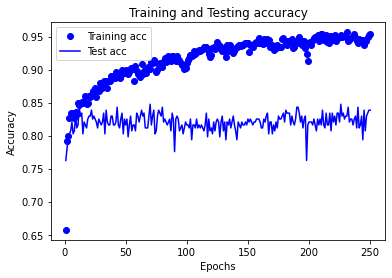

In [35]:
plot_training(history.history)

The above model is overfitting (we can tell by the graph above). The distance between the training accuracy and validation accuracy is very high

# Improve overfitting by avoiding or reducing over fitting

## 1. Reduce complexity of model

In [36]:
# ===============================================================# 
#                  Things that have changed
#
# hidden_layers = 3 -> 1
# hidden_layer_neurons = 128 -> 32
# ===============================================================#

# Define network
number_features = X_train_sc.shape[1]
model = make_net (number_features,
                  hidden_layers = 1,
                  hidden_layer_neurons = 32)

# Train model and store training info in history

history = model.fit (X_train_sc, 
                     y_train,
                     epochs = 250,
                     batch_size = 64,
                     validation_data = (X_test_sc, y_test),
                     verbose = 1)

Train on 668 samples, validate on 223 samples
Epoch 1/250
668/668 [==============================] - 0s 594us/sample - loss: 0.9812 - accuracy: 0.3757 - val_loss: 0.8011 - val_accuracy: 0.4036
Epoch 2/250
668/668 [==============================] - 0s 64us/sample - loss: 0.7369 - accuracy: 0.4147 - val_loss: 0.6576 - val_accuracy: 0.7220
Epoch 3/250
668/668 [==============================] - 0s 67us/sample - loss: 0.6200 - accuracy: 0.7036 - val_loss: 0.5851 - val_accuracy: 0.7040
Epoch 4/250
668/668 [==============================] - 0s 58us/sample - loss: 0.5649 - accuracy: 0.7021 - val_loss: 0.5526 - val_accuracy: 0.6996
Epoch 5/250
668/668 [==============================] - 0s 55us/sample - loss: 0.5367 - accuracy: 0.7216 - val_loss: 0.5254 - val_accuracy: 0.7085
Epoch 6/250
668/668 [==============================] - 0s 57us/sample - loss: 0.5118 - accuracy: 0.7470 - val_loss: 0.5077 - val_accuracy: 0.7578
Epoch 7/250
668/668 [==============================] - 0s 55us/sample - loss:

668/668 [==============================] - 0s 58us/sample - loss: 0.3838 - accuracy: 0.8353 - val_loss: 0.4202 - val_accuracy: 0.8117
Epoch 57/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3839 - accuracy: 0.8293 - val_loss: 0.4230 - val_accuracy: 0.8117
Epoch 58/250
668/668 [==============================] - 0s 51us/sample - loss: 0.3848 - accuracy: 0.8473 - val_loss: 0.4177 - val_accuracy: 0.8161
Epoch 59/250
668/668 [==============================] - 0s 54us/sample - loss: 0.3811 - accuracy: 0.8338 - val_loss: 0.4246 - val_accuracy: 0.8117
Epoch 60/250
668/668 [==============================] - 0s 51us/sample - loss: 0.3809 - accuracy: 0.8308 - val_loss: 0.4184 - val_accuracy: 0.8161
Epoch 61/250
668/668 [==============================] - 0s 51us/sample - loss: 0.3818 - accuracy: 0.8518 - val_loss: 0.4171 - val_accuracy: 0.8206
Epoch 62/250
668/668 [==============================] - 0s 49us/sample - loss: 0.3782 - accuracy: 0.8323 - val_loss: 0.4245 - val_a

Epoch 112/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3322 - accuracy: 0.8638 - val_loss: 0.4239 - val_accuracy: 0.8206
Epoch 113/250
668/668 [==============================] - 0s 54us/sample - loss: 0.3313 - accuracy: 0.8668 - val_loss: 0.4301 - val_accuracy: 0.8296
Epoch 114/250
668/668 [==============================] - 0s 57us/sample - loss: 0.3313 - accuracy: 0.8638 - val_loss: 0.4283 - val_accuracy: 0.8251
Epoch 115/250
668/668 [==============================] - 0s 52us/sample - loss: 0.3296 - accuracy: 0.8653 - val_loss: 0.4268 - val_accuracy: 0.8206
Epoch 116/250
668/668 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.89 - 0s 58us/sample - loss: 0.3294 - accuracy: 0.8593 - val_loss: 0.4247 - val_accuracy: 0.8251
Epoch 117/250
668/668 [==============================] - 0s 57us/sample - loss: 0.3283 - accuracy: 0.8638 - val_loss: 0.4312 - val_accuracy: 0.8296
Epoch 118/250
668/668 [==============================] - 0s 54us/sampl

668/668 [==============================] - 0s 57us/sample - loss: 0.3004 - accuracy: 0.8892 - val_loss: 0.4574 - val_accuracy: 0.8206
Epoch 168/250
668/668 [==============================] - 0s 57us/sample - loss: 0.3024 - accuracy: 0.8787 - val_loss: 0.4553 - val_accuracy: 0.8251
Epoch 169/250
668/668 [==============================] - 0s 55us/sample - loss: 0.3005 - accuracy: 0.8847 - val_loss: 0.4600 - val_accuracy: 0.8206
Epoch 170/250
668/668 [==============================] - 0s 51us/sample - loss: 0.3038 - accuracy: 0.8802 - val_loss: 0.4601 - val_accuracy: 0.8161
Epoch 171/250
668/668 [==============================] - 0s 54us/sample - loss: 0.3019 - accuracy: 0.8832 - val_loss: 0.4632 - val_accuracy: 0.8206
Epoch 172/250
668/668 [==============================] - 0s 55us/sample - loss: 0.2992 - accuracy: 0.8817 - val_loss: 0.4584 - val_accuracy: 0.8251
Epoch 173/250
668/668 [==============================] - 0s 55us/sample - loss: 0.2984 - accuracy: 0.8877 - val_loss: 0.4635 -

668/668 [==============================] - 0s 57us/sample - loss: 0.2799 - accuracy: 0.8892 - val_loss: 0.5007 - val_accuracy: 0.8206
Epoch 223/250
668/668 [==============================] - 0s 58us/sample - loss: 0.2789 - accuracy: 0.8907 - val_loss: 0.4959 - val_accuracy: 0.8206
Epoch 224/250
668/668 [==============================] - 0s 54us/sample - loss: 0.2795 - accuracy: 0.8982 - val_loss: 0.5008 - val_accuracy: 0.8161
Epoch 225/250
668/668 [==============================] - 0s 55us/sample - loss: 0.2818 - accuracy: 0.8862 - val_loss: 0.4978 - val_accuracy: 0.8117
Epoch 226/250
668/668 [==============================] - 0s 54us/sample - loss: 0.2833 - accuracy: 0.8967 - val_loss: 0.5016 - val_accuracy: 0.8206
Epoch 227/250
668/668 [==============================] - 0s 54us/sample - loss: 0.2787 - accuracy: 0.8907 - val_loss: 0.5016 - val_accuracy: 0.8206
Epoch 228/250
668/668 [==============================] - 0s 55us/sample - loss: 0.2782 - accuracy: 0.8937 - val_loss: 0.5013 -

In [37]:
# Show accuracy
calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.897
Test accuracy:   0.821


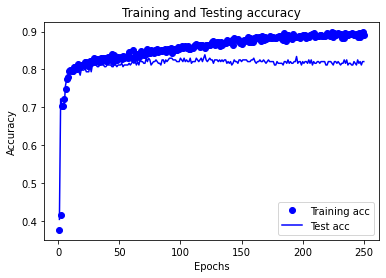

In [38]:
# Plot training and testing accuracy
plot_training(history.history)

## 2. Reduce Training Time

In [40]:
# ===============================================================# 
#                  Things that have changed
#
# epochs = 250 -> 25
# ===============================================================#

# Define network
number_features = X_train_sc.shape[1]
model = make_net (number_features)

# Train model and store training info in history

history = model.fit (X_train_sc, 
                     y_train,
                     epochs = 25,
                     batch_size = 64,
                     validation_data = (X_test_sc, y_test),
                     verbose = 1)

Train on 668 samples, validate on 223 samples
Epoch 1/25
668/668 [==============================] - 0s 696us/sample - loss: 0.5992 - accuracy: 0.6692 - val_loss: 0.5000 - val_accuracy: 0.7578
Epoch 2/25
668/668 [==============================] - 0s 61us/sample - loss: 0.4765 - accuracy: 0.7874 - val_loss: 0.4702 - val_accuracy: 0.7848
Epoch 3/25
668/668 [==============================] - 0s 58us/sample - loss: 0.4519 - accuracy: 0.7949 - val_loss: 0.4456 - val_accuracy: 0.7982
Epoch 4/25
668/668 [==============================] - 0s 58us/sample - loss: 0.4316 - accuracy: 0.8174 - val_loss: 0.4426 - val_accuracy: 0.8161
Epoch 5/25
668/668 [==============================] - 0s 58us/sample - loss: 0.4178 - accuracy: 0.8263 - val_loss: 0.4306 - val_accuracy: 0.8027
Epoch 6/25
668/668 [==============================] - 0s 58us/sample - loss: 0.4037 - accuracy: 0.8263 - val_loss: 0.4443 - val_accuracy: 0.8251
Epoch 7/25
668/668 [==============================] - 0s 60us/sample - loss: 0.3974

In [41]:
# Show accuracy
calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.889
Test accuracy:   0.812


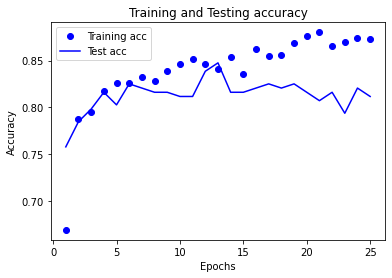

In [42]:
# Plot Training and Testing accuracy
plot_training (history.history)

## 3. Add Dropout
Using Dropout, in each training epoch a random selection of weights are not used (the selection changes from epoch to epoch)

Most common values for dropout are between 0.2 to 0.5 (20% to 50% weights are not used)

In [43]:
# ===============================================================# 
#                  Things that have changed
#
# dropout = 0 -> 0.5
# ===============================================================#

# Define network
number_features = X_train_sc.shape[1]
model = make_net (number_features,
                  dropout = 0.5)

# Train model and store training info in history
history = model.fit (X_train_sc, 
                     y_train,
                     epochs = 250,
                     batch_size = 64,
                     validation_data = (X_test_sc, y_test),
                     verbose = 1)

Train on 668 samples, validate on 223 samples
Epoch 1/250
668/668 [==============================] - 1s 812us/sample - loss: 0.6357 - accuracy: 0.6063 - val_loss: 0.5898 - val_accuracy: 0.6457
Epoch 2/250
668/668 [==============================] - 0s 69us/sample - loss: 0.5920 - accuracy: 0.6886 - val_loss: 0.5203 - val_accuracy: 0.7489
Epoch 3/250
668/668 [==============================] - 0s 61us/sample - loss: 0.5228 - accuracy: 0.7635 - val_loss: 0.4827 - val_accuracy: 0.7534
Epoch 4/250
668/668 [==============================] - 0s 60us/sample - loss: 0.5075 - accuracy: 0.7725 - val_loss: 0.4737 - val_accuracy: 0.8027
Epoch 5/250
668/668 [==============================] - 0s 60us/sample - loss: 0.4970 - accuracy: 0.7784 - val_loss: 0.4570 - val_accuracy: 0.7982
Epoch 6/250
668/668 [==============================] - 0s 66us/sample - loss: 0.4732 - accuracy: 0.7994 - val_loss: 0.4659 - val_accuracy: 0.7982
Epoch 7/250
668/668 [==============================] - 0s 61us/sample - loss:

668/668 [==============================] - 0s 64us/sample - loss: 0.3638 - accuracy: 0.8503 - val_loss: 0.5232 - val_accuracy: 0.8296
Epoch 57/250
668/668 [==============================] - 0s 66us/sample - loss: 0.3536 - accuracy: 0.8533 - val_loss: 0.5195 - val_accuracy: 0.8161
Epoch 58/250
668/668 [==============================] - 0s 62us/sample - loss: 0.3650 - accuracy: 0.8533 - val_loss: 0.5326 - val_accuracy: 0.8161
Epoch 59/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3611 - accuracy: 0.8563 - val_loss: 0.5226 - val_accuracy: 0.8206
Epoch 60/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3541 - accuracy: 0.8518 - val_loss: 0.5269 - val_accuracy: 0.8251
Epoch 61/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3507 - accuracy: 0.8533 - val_loss: 0.5502 - val_accuracy: 0.8251
Epoch 62/250
668/668 [==============================] - 0s 63us/sample - loss: 0.3620 - accuracy: 0.8503 - val_loss: 0.5212 - val_a

Epoch 112/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3525 - accuracy: 0.8473 - val_loss: 0.6206 - val_accuracy: 0.8386
Epoch 113/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3373 - accuracy: 0.8668 - val_loss: 0.6302 - val_accuracy: 0.8206
Epoch 114/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3356 - accuracy: 0.8473 - val_loss: 0.5724 - val_accuracy: 0.8206
Epoch 115/250
668/668 [==============================] - 0s 60us/sample - loss: 0.3181 - accuracy: 0.8713 - val_loss: 0.5968 - val_accuracy: 0.8251
Epoch 116/250
668/668 [==============================] - 0s 57us/sample - loss: 0.3284 - accuracy: 0.8698 - val_loss: 0.6084 - val_accuracy: 0.8296
Epoch 117/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3294 - accuracy: 0.8683 - val_loss: 0.6065 - val_accuracy: 0.8341
Epoch 118/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3278 - accuracy: 0.8623 - val_

668/668 [==============================] - 0s 64us/sample - loss: 0.3076 - accuracy: 0.8847 - val_loss: 0.6985 - val_accuracy: 0.8251
Epoch 168/250
668/668 [==============================] - 0s 66us/sample - loss: 0.2998 - accuracy: 0.8802 - val_loss: 0.7509 - val_accuracy: 0.8251
Epoch 169/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3059 - accuracy: 0.8787 - val_loss: 0.6784 - val_accuracy: 0.8117
Epoch 170/250
668/668 [==============================] - 0s 63us/sample - loss: 0.3064 - accuracy: 0.8728 - val_loss: 0.6802 - val_accuracy: 0.8206
Epoch 171/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3031 - accuracy: 0.8847 - val_loss: 0.7159 - val_accuracy: 0.8251
Epoch 172/250
668/668 [==============================] - 0s 57us/sample - loss: 0.2929 - accuracy: 0.8892 - val_loss: 0.7275 - val_accuracy: 0.8206
Epoch 173/250
668/668 [==============================] - 0s 63us/sample - loss: 0.2967 - accuracy: 0.8757 - val_loss: 0.7327 -

668/668 [==============================] - 0s 63us/sample - loss: 0.2824 - accuracy: 0.8817 - val_loss: 0.8324 - val_accuracy: 0.8027
Epoch 223/250
668/668 [==============================] - 0s 60us/sample - loss: 0.2785 - accuracy: 0.8862 - val_loss: 0.8784 - val_accuracy: 0.8072
Epoch 224/250
668/668 [==============================] - 0s 61us/sample - loss: 0.2838 - accuracy: 0.8668 - val_loss: 0.8780 - val_accuracy: 0.8072
Epoch 225/250
668/668 [==============================] - 0s 61us/sample - loss: 0.2965 - accuracy: 0.8817 - val_loss: 0.8653 - val_accuracy: 0.8206
Epoch 226/250
668/668 [==============================] - 0s 67us/sample - loss: 0.2781 - accuracy: 0.8892 - val_loss: 0.9100 - val_accuracy: 0.8161
Epoch 227/250
668/668 [==============================] - 0s 61us/sample - loss: 0.2892 - accuracy: 0.8817 - val_loss: 0.8644 - val_accuracy: 0.8251
Epoch 228/250
668/668 [==============================] - 0s 60us/sample - loss: 0.2925 - accuracy: 0.8757 - val_loss: 0.7676 -

In [44]:
# Show accuracy
calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.901
Test accuracy:   0.825


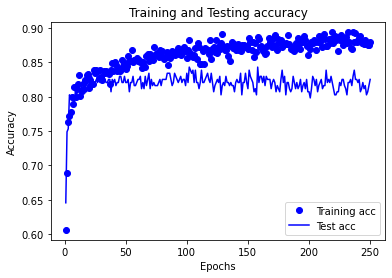

In [45]:
# Plot Training and Testing accuracy
plot_training (history.history)

## 4. Combination of the above with automatic early stopping

In [46]:
# Define save checkpoint callback (only save if new best validation resuts)
checkpoint_cb = keras.callbacks.ModelCheckpoint (
    'model_checkpoint.h5', save_best_only = True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best vaildation accuracy

early_stopping_cb = keras.callbacks.EarlyStopping (
    patience = 25, restore_best_weights = True)

# Define Network
number_features = X_train_sc.shape [1]
model = make_net (number_features,
                  hidden_layers = 1,
                  hidden_layer_neurons = 64,
                  dropout = 0.5)

# Train the model and store training info in history
history = model.fit (X_train_sc,
                     y_train,
                     epochs = 250,
                     batch_size = 64,
                     validation_data = (X_test_sc, y_test),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Train on 668 samples, validate on 223 samples
Epoch 1/250
668/668 [==============================] - 1s 815us/sample - loss: 0.6306 - accuracy: 0.6557 - val_loss: 0.5814 - val_accuracy: 0.6906
Epoch 2/250
668/668 [==============================] - 0s 106us/sample - loss: 0.5760 - accuracy: 0.7021 - val_loss: 0.5498 - val_accuracy: 0.7040
Epoch 3/250
668/668 [==============================] - 0s 97us/sample - loss: 0.5560 - accuracy: 0.7320 - val_loss: 0.5239 - val_accuracy: 0.7444
Epoch 4/250
668/668 [==============================] - 0s 97us/sample - loss: 0.5179 - accuracy: 0.7365 - val_loss: 0.5043 - val_accuracy: 0.7534
Epoch 5/250
668/668 [==============================] - 0s 101us/sample - loss: 0.5043 - accuracy: 0.7635 - val_loss: 0.4931 - val_accuracy: 0.7623
Epoch 6/250
668/668 [==============================] - 0s 85us/sample - loss: 0.4994 - accuracy: 0.7590 - val_loss: 0.4822 - val_accuracy: 0.7534
Epoch 7/250
668/668 [==============================] - 0s 88us/sample - los

668/668 [==============================] - 0s 93us/sample - loss: 0.4021 - accuracy: 0.8338 - val_loss: 0.4291 - val_accuracy: 0.8206
Epoch 57/250
668/668 [==============================] - 0s 55us/sample - loss: 0.3905 - accuracy: 0.8368 - val_loss: 0.4309 - val_accuracy: 0.8072
Epoch 58/250
668/668 [==============================] - 0s 87us/sample - loss: 0.4110 - accuracy: 0.8383 - val_loss: 0.4271 - val_accuracy: 0.8117
Epoch 59/250
668/668 [==============================] - 0s 61us/sample - loss: 0.3880 - accuracy: 0.8308 - val_loss: 0.4346 - val_accuracy: 0.8072
Epoch 60/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3925 - accuracy: 0.8323 - val_loss: 0.4330 - val_accuracy: 0.8117
Epoch 61/250
668/668 [==============================] - 0s 58us/sample - loss: 0.3987 - accuracy: 0.8383 - val_loss: 0.4292 - val_accuracy: 0.8072
Epoch 62/250
668/668 [==============================] - 0s 96us/sample - loss: 0.3971 - accuracy: 0.8428 - val_loss: 0.4266 - val_a

In [47]:
# Show accuracy
calculate_accuracy (model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.846
Test accuracy:   0.830


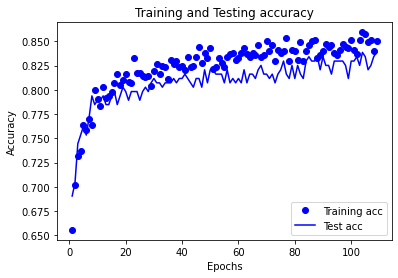

In [48]:
# Plot Training and Testing accuracy
plot_training (history.history)

# Saving and reloading a model

In [49]:
# Save model
model.save ('titanic_tf_model.h5')             # .h5 extension is convention

# Load and use saved model 
loaded_model = keras.models.load_model ('titanic_tf_model.h5')

# Predict class using a saved model
predicted_proba = loaded_model.predict (X_test_sc)

# Show examples of predicted probaility
print (predicted_proba[0:5].flatten())

[0.12812869 0.12769917 0.13408527 0.9161071  0.56769425]


In [50]:
calculate_accuracy (loaded_model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy:  0.846
Test accuracy:   0.830
